# Neural Networks - ANNs in Keras 

# GPU in colab
First, you'll need to enable GPUs for the notebook:
*   Navigate to Edit→Notebook Settings
*   select GPU from the Hardware Accelerator drop-down


# Importing Packages

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Mapping, List

# Demonstration of the theory

# Importing Fashion MNIST dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Checking the number of samples and dimensionality of images

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

The data represents images of 

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

Checking the labels in ``y_train``

In [ ]:
unique_y = np.unique(y_train)
numb_labels = unique_y.size # total number of labels
unique_y

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Plotting images in different categories

In [ ]:
# first finding indices for each of digit category
unique_indc = np.zeros(numb_labels , dtype=int)
for k, item in enumerate(unique_y):
    unique_indc[k] = np.where(y_train == item)[0][0]

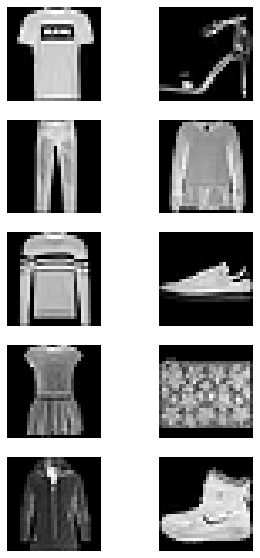

In [ ]:
nrows = 5
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5,10))
column = 0
for k, digit in enumerate(X_train[unique_indc]):
    row = k%nrows
    if k==nrows:
        column+=1
    ax[row][column].imshow(digit, cmap="gray")    
    ax[row][column].axis("off")
plt.show()

Changing y values to categorical namely having 10 clothing items, 

e.g., t-shirt will become

``[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]``

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, numb_labels)
y_test =  tf.keras.utils.to_categorical(y_test, numb_labels)

In [ ]:
y_train[0] # what label does it have? 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

## Tensors - multidimensional arrays

Our images are grayscale, they are matrices so that each entry of a matrix is a pixel whose number represents the intensity of the colour, 
- 0 represents black and 
- 255 represents white.

We can think that grayscale images have only one colour channel, what about the colour images? 

Colour may be important for a classification task. 

Colour images are represented as 3 matrices, 
- the first matrix is for RED channel, 255 represents RED and 0 BLACK;
- the second matrix is for GREEN channel, 255 represents GREEN and 0 BLACK;
- the third matrix is for the BLUE channel, 255 represents BLUE and 0 BLACK;

Rather than having 3 different matrices, we combain them into one array, we call this multidimensional array a tensor. 

Given a colour image of size $p \times q$ the shape of the tensor will be

`` (p, q, 3) `` where 3 indicates that there are 3 colour channels. 

Having $N$ colour images we will store tham in a tensor of the shape:

`` (N, p, q, 3)``

To get used to tensor structure let's convert our digits to tensor with 1 channel. 


In [ ]:
X_train = X_train.reshape(-1, 28, 28,1)
X_test = X_test.reshape(-1, 28, 28,1)

print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## Preprocessing an image

Later we will learn how to properly pre-process images. Now we will do a small tweak, as neural networks work better with numbers between 0 and 1, let's scale our images:

In [ ]:
X_train = X_train/255 
X_test = X_test/255

In [ ]:
print(X_train.min(), X_train.max())

0.0 1.0


# Building a feedforward neural network for MNIST

For our neural networks we will be using SEQUENTIAL KERAS API, this means that we will be adding layer after layer in a sequence. 

Let's set up our model:



In [ ]:
mnist_model = tf.keras.Sequential()

At the moment it is empty, we need to add some layers. 

**Wait a second** We studied the neural networks so that their input was a vector, not a matrix or tensor. 

To handle that we first add the FLATTENING layer, that will flatten the input so that it is a vector. 

In [ ]:
mnist_model.add(tf.keras.layers.Flatten())

Now we add a couple of hidden-layers, these are called DENSE layers in KERAS API

In [ ]:
mnist_model.add(tf.keras.layers.Dense(32, activation="relu"))
mnist_model.add(tf.keras.layers.Dense(16, activation="relu"))

Note that we choose an activation functino for this layers to be ReLU, remember $ReLU(x) = \max\{0, x\}$.

Now we will add the OUTPUT LAYER, it need to have the right number of nodes in the output to match our categorical ``y_train``.

In [ ]:
mnist_model.add(tf.keras.layers.Dense(numb_labels, activation='softmax'))

We equipped the output layer with the ``softmax`` activation function, which ensures that each of the entry of the output vector of size $10$ is a valid probability. The highest probability cell corresponds to the digit. 

SOFTMAX is a multidimensional analogue of logistic function (sigmoid function). 

For a vector $z = (z_1, \ldots, z_n) \in \mathbb{R}^n$ the value of the softmax function $\sigma(z) = (\sigma(z)_1, \sigma(z)_2, \ldots, \sigma(z)_n)$ where
$$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}$$

If we wish to define it by hand it is given by 

In [ ]:
import numpy as np

def softmax(x):
    output = np.exp(x) / np.sum(np.exp(x))
    return output

x = np.array([0.5, 1.0, 3.0])
print(softmax(x))

[0.06742536 0.11116562 0.82140902]


### Selecting the LOSS function, the metrics for ACCURACY and the OPTIMIZER. 

For classification problems we will pick **categorical cross-entropy** loss  function.

As score metrics we will pick **accuracy**.

For an optimizer let's use **STOCHASTIC GRADIENT DESCENT** (SGD). 


In [ ]:
loss = 'categorical_crossentropy'

metrics = ["accuracy"] # metrics need to be in a list format
# we may want to have more metrics

# select learning rate for the optimizer
learning_rate = 1e-02 # this is 10^(-2)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Let us complie the model now

In [ ]:
mnist_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Checkpoints

During training we may want to save weights to a file.

We only want to save the weights if we did better than the current best result.

If we run the training too long, the network will overfit, and the accuracy will drop. Setting a checkpoint will prevent saving the weights that were giving low validation accuracy. 



In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "mnist_model.h5",  # file for our weights
    monitor="val_accuracy",  # we monitor validation accuracy
    verbose=1,  # how verbal the model is,
    save_best_only=True, # we only want to save the best weights
    mode='max' # we want maximal validation accuracy, if the monotir was validation loss then we would like to have the mode to be min instead
    )

callbacks_list = [checkpoint] # there may be more callbacks so we save it inside the list

# Training the Network

Let's select a number of epochs, let's set it for 5 to beging with. 

In [ ]:
EPOCHS = 5

Now we will fit the model

In [ ]:
history = mnist_model.fit(
    X_train,
    y_train, 
    epochs=EPOCHS, 
    validation_data=(X_test, y_test), 
    callbacks=callbacks_list)

Epoch 1/5
1873/1875 [============================>.] - ETA: 0s - loss: 0.8842 - accuracy: 0.6947
Epoch 1: val_accuracy improved from -inf to 0.78150, saving model to mnist_model.h5
1875/1875 [==============================] - 10s 4ms/step - loss: 0.8841 - accuracy: 0.6948 - val_loss: 0.6193 - val_accuracy: 0.7815
Epoch 2/5
1870/1875 [============================>.] - ETA: 0s - loss: 0.5429 - accuracy: 0.8107
Epoch 2: val_accuracy improved from 0.78150 to 0.81640, saving model to mnist_model.h5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5429 - accuracy: 0.8106 - val_loss: 0.5253 - val_accuracy: 0.8164
Epoch 3/5
1863/1875 [============================>.] - ETA: 0s - loss: 0.4816 - accuracy: 0.8332
Epoch 3: val_accuracy improved from 0.81640 to 0.82550, saving model to mnist_model.h5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4813 - accuracy: 0.8333 - val_loss: 0.5013 - val_accuracy: 0.8255
Epoch 4/5
1860/1875 [============================>.

# Model summary

We can display the model structure, it will also show us how many parameters (weights, biases) there is for the training. 

In [ ]:
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
_________________________________________________________________


# Plotting TRAINING AND VALIDATION curves

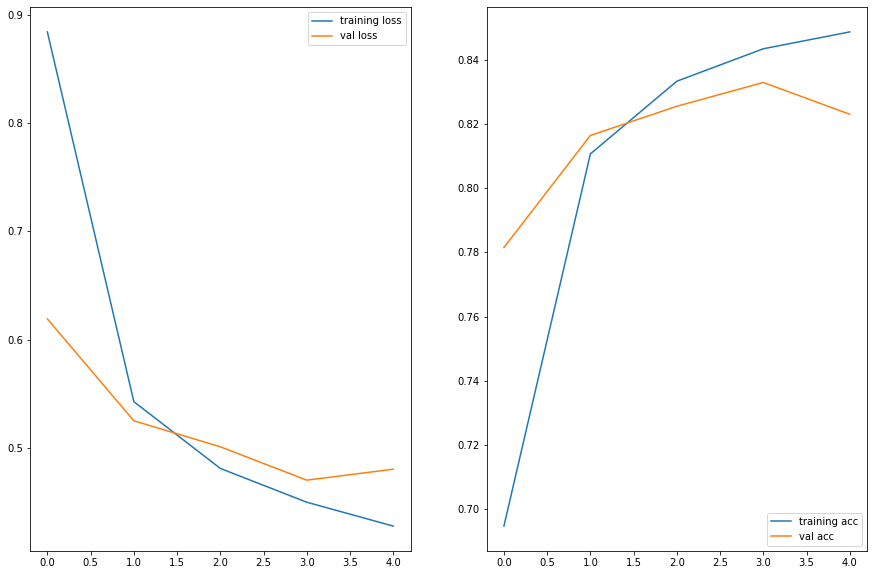

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend(loc='lower right')

plt.show()

## Evaluating the model 

In [ ]:
mnist_model.load_weights("mnist_model.h5") # we load the best weights 

test_loss, test_acc = mnist_model.evaluate(X_test,  y_test) # we get the test loss and accyracy scores.
print(f'Test accuracy:{test_acc}, Test loss: {test_loss}')

313/313 [==============================] - 1s 4ms/step - loss: 0.4705 - accuracy: 0.8329
Test accuracy:0.8328999876976013, Test loss: 0.4704991281032562


# Confusion matrix

We produce the confusion matrix of our model. 

A **confusion matrix** contains a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class.

In [ ]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = mnist_model.predict(X_test)

In [ ]:
y_test_flat = y_test.argmax(axis=1) # converting back from categorical to label
y_pred_flat = y_pred.argmax(axis=1) # converting back from categorical to label

In [ ]:
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat) # confusion matrix
conf_matrix

array([[817,   6,  10,  63,   7,   4,  75,   0,  18,   0],
       [  2, 950,   3,  29,  13,   0,   2,   0,   1,   0],
       [ 20,   2, 641,  10, 218,   2,  93,   0,  14,   0],
       [ 34,  12,  10, 856,  46,   0,  36,   0,   4,   2],
       [  0,   2,  51,  33, 845,   1,  60,   0,   8,   0],
       [  0,   0,   0,   1,   0, 900,   0,  54,   6,  39],
       [165,   1, 100,  54, 149,   1, 501,   0,  29,   0],
       [  0,   0,   0,   0,   0,  30,   0, 911,   0,  59],
       [  3,   1,   6,   7,   7,   5,  14,   5, 952,   0],
       [  0,   0,   0,   0,   0,  12,   0,  31,   1, 956]])

In [ ]:
conf_matrix.shape

(10, 10)

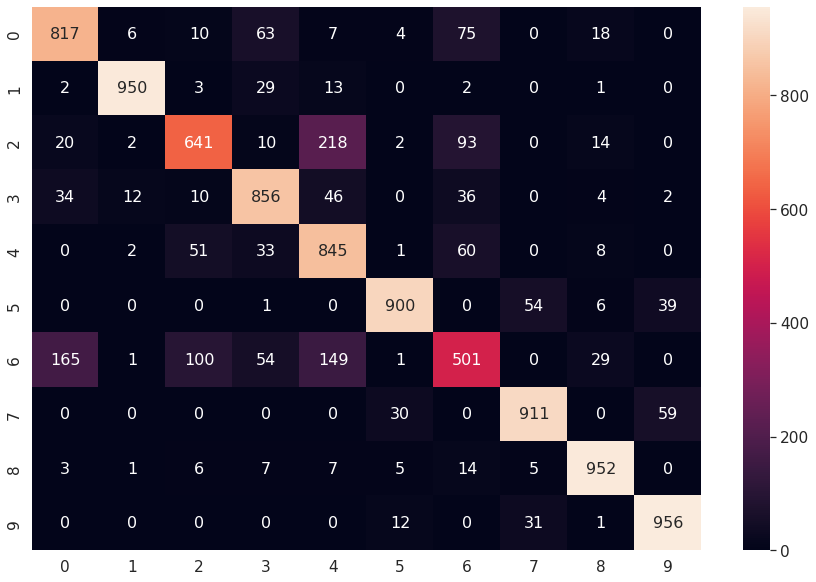

In [ ]:
index_conf = np.arange(conf_matrix.shape[0])
df_cm = pd.DataFrame(conf_matrix, index_conf, index_conf)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()